# XGBoost

In [3]:
# Bloc non affiché

import numpy as np
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix,accuracy_score,r2_score, matthews_corrcoef, make_scorer


from sklearn.svm import NuSVC
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from xgboost import XGBClassifier
from xgboost import XGBRFClassifier
from xgboost import plot_importance

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn import datasets, ensemble

import imblearn


def result_model(model,X,Y) :
    Y_model =model.predict(X)

    f1_scor = f1_score(Y,Y_model)
    print('Le f1 score vaut',f1_scor)
    
#     score = cross_val_score(model,X,Y,cv=5,scoring = make_scorer(f1_score))
#     print('F1 cross validé :', np.mean(score))
    
   # Matrice de confusion
    cm_model = confusion_matrix(Y, Y_model)
    plt.rcParams['figure.figsize'] = (5, 5)
    sns.heatmap(cm_model, annot = True)
    plt.title(str(model))
    plt.show()
    
    return(f1_scor)

## Téléchargement des données

In [4]:
train = pd.read_csv("https://www.data.mclavier.com/prj_datascience/train_v1.csv")

## Pre-processing

On sépare dans un premier temps les variables explicatives et la variable à expliquer.

In [6]:
# Variables explicative
exp_var = train.columns[:-1]

# Décomposition features / target
X = train[exp_var]
Y = train['Response']

Ensuite, on décompose en bdd train et test puis on scale les données grâce à sklearn.

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,train_size = 0.95)

scaler=StandardScaler() 

X_scal_train = scaler.fit_transform(X_train)
X_scal_test = scaler.transform(X_test) 

X_scal_train = pd.DataFrame(X_scal_train,index= X_train.index, columns=exp_var)
X_scal_test = pd.DataFrame(X_scal_test,index= X_test.index, columns=exp_var)

## Modèle

In [33]:
xgb = XGBClassifier(use_label_encoder=False, objective = 'reg:squarederror')
xgb.fit(X, Y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='reg:squarederror',
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

Le f1 score vaut 0.4970414201183433


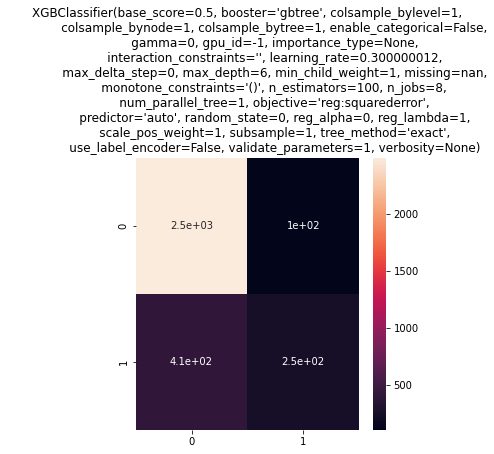

In [34]:
f1 = result_model(xgb, X_test, Y_test)

## Tuning

Pour tuner le programme, on s'inspire grandement de [ce site](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/#h2_9).

In [35]:
#Import libraries:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

target = 'Response'

In [36]:
def modelfit(alg, dtrain, predictors, useTrainCV = True, cv_folds=5, early_stopping_rounds=50):

    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])

    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nMesures :")
    print("---------")
    print("Accuracy : ", accuracy_score(dtrain[target].values, dtrain_predictions))
    print("f1 : ", f1_score(dtrain[target].values, dtrain_predictions))


    plot_importance(xgb1)
    plt.show()


Mesures :
---------
Accuracy :  0.8117540437166864
f1 :  0.37099009392803983


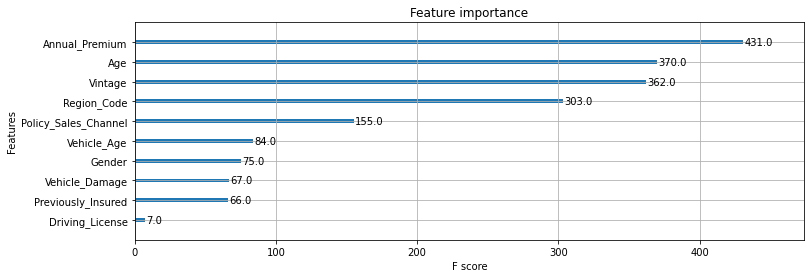

In [39]:
predictors = [x for x in train.columns if x not in [target]]
xgb1 = XGBClassifier(
    use_label_encoder=False,
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27)
modelfit(xgb1, train, predictors)

### Etape 2

On tune max_depth et min_child_weight

In [40]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6)
}
gsearch1 = GridSearchCV(
    estimator = XGBClassifier(use_label_encoder=False,
                            learning_rate =0.1, n_estimators=140, max_depth=5,
                            min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                            objective= 'binary:logistic', nthread=7, scale_pos_weight=1, seed=27),
    param_grid = param_test1, scoring='f1', n_jobs=4, cv=5)
 
gsearch1.fit(train[predictors],train[target])

[08:37:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'max_depth': 9, 'min_child_weight': 3}, 0.3899452945843579)

In [ ]:
gsearch1.best_params_, gsearch1.best_score_

On teste entre les deux, un peu plus haut et un peu plus bas

In [41]:
param_test2 = {
 'max_depth':[9, 20,45, 50, 75],
}

gsearch2 = GridSearchCV(
                estimator = XGBClassifier(use_label_encoder=False,
                            learning_rate=0.1, n_estimators=140, max_depth=9,
                            min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
                            objective= 'binary:logistic', nthread=7, scale_pos_weight=1,seed=27), 
                param_grid = param_test2, scoring='f1',n_jobs=4,cv=5)

gsearch2.fit(train[predictors],train[target])
gsearch2.best_params_, gsearch2.best_score_

[08:42:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'max_depth': 75}, 0.4063809999388549)

Si on est à une valeur optimale on peut tester plus haut

In [57]:
param_test2b = {
    'max_depth':[10, 12, 14],
    'min_child_weight':[4,6,8]
}

gsearch2b = GridSearchCV(
                estimator = XGBClassifier(use_label_encoder=False,
                                learning_rate=0.1, n_estimators=140, max_depth=10,
                                min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                param_grid = param_test2b, scoring='f1',n_jobs=4, cv=5)

gsearch2b.fit(train[predictors],train[target])
gsearch2b.best_params_, gsearch2b.best_score_

C:\Users\mathi\.virtualenvs\ISFA-prj-datascience-4Z2Vzt1R\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:23:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'max_depth': 14, 'min_child_weight': 4}, 0.3993741715926763)

In [60]:
param_test2c = {
   'max_depth':[14, 40, 50, 60]
}

gsearch2c = GridSearchCV(
               estimator = XGBClassifier(use_label_encoder=False,
                              learning_rate=0.1, n_estimators=140, max_depth=14,
                              min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,
                              objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
               param_grid = param_test2c, scoring='f1',n_jobs=4, cv=5)

gsearch2c.fit(train[predictors],train[target])
gsearch2c.best_params_, gsearch2c.best_score_

C:\Users\mathi\.virtualenvs\ISFA-prj-datascience-4Z2Vzt1R\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:35:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'max_depth': 300}, 0.4070579630517889)

In [43]:
param_test2d = {
    'max_depth':[9, 30, 40, 45, 50]
}

gsearch2d = GridSearchCV(
                estimator = XGBClassifier(use_label_encoder=False,
                                learning_rate=0.1, n_estimators=140, max_depth=50,
                                min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                objective= 'binary:logistic', nthread=7, scale_pos_weight=1,seed=27), 
                param_grid = param_test2d, scoring='f1',n_jobs=4, cv=5)
                
gsearch2d.fit(train[predictors],train[target])


[08:59:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     enable_categorical=False, gamma=0,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=50, min_child_weight=3,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=140, n_jobs=None, nthread=7,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weigh

In [44]:
gsearch2d.best_params_, gsearch2d.best_score_

({'max_depth': 45}, 0.4079003239560688)

### Etape 3 : Gamma

Now lets tune gamma value using the parameters already tuned above. Gamma can take various values but I’ll check for 5 values here. You can go into more precise values as.

In [68]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=50,
                                    min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                    objective= 'binary:logistic', nthread=7, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='f1',n_jobs=4, cv=5)
gsearch3.fit(train[predictors],train[target])
gsearch3.best_params_, gsearch3.best_score_

C:\Users\mathi\.virtualenvs\ISFA-prj-datascience-4Z2Vzt1R\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:30:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'gamma': 0.0}, 0.4082568393752803)

This shows that our original value of gamma, i.e. 0 is the optimum one. Before proceeding, a good idea would be to re-calibrate the number of boosting rounds for the updated parameters.

In [70]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=50,
 min_child_weight=4,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=7,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb2, train, predictors)


Model Report
Accuracy :  0.8925208522142517
f1 :  0.682084601753828


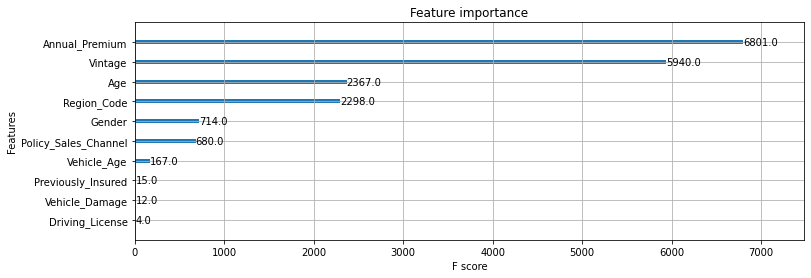

In [71]:
plot_importance(xgb2)
plt.show()

### Etape 4 : Tune subsample et colsample_bytree

In [72]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=50,
                                    min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                    objective= 'binary:logistic', nthread=7, scale_pos_weight=1,seed=27), 
            param_grid = param_test4, scoring='f1',n_jobs=4, cv=5)
gsearch4.fit(train[predictors],train[target])
gsearch4.best_params_, gsearch4.best_score_

C:\Users\mathi\.virtualenvs\ISFA-prj-datascience-4Z2Vzt1R\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:59:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'colsample_bytree': 0.9, 'subsample': 0.8}, 0.41359545491739375)

Here, we found 0.8 as the optimum value for both subsample and colsample_bytree. Now we should try values in 0.05 interval around these.

In [78]:
param_test5 = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(85,100,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=50,
                             min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.9,
                            objective= 'binary:logistic', nthread=7, scale_pos_weight=1,seed=27), 
            param_grid = param_test5, scoring='f1',n_jobs=4, cv=5)
gsearch5.fit(train[predictors],train[target])
gsearch5.best_params_, gsearch5.best_score_

C:\Users\mathi\.virtualenvs\ISFA-prj-datascience-4Z2Vzt1R\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:19:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'colsample_bytree': 0.9, 'subsample': 0.8}, 0.4117609417997697)

### Step 5: Tuning Regularization Parameters

Next step is to apply regularization to reduce overfitting. Though many people don’t use this parameters much as gamma provides a substantial way of controlling complexity. But we should always try it. I’ll tune ‘reg_alpha’ value here and leave it upto you to try different values of ‘reg_lambda’.

In [79]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=50,
                                 min_child_weight=4, gamma=0.1, subsample=0.8, colsample_bytree=0.9,
                                 objective= 'binary:logistic', nthread=7, scale_pos_weight=1,seed=27), 
                        param_grid = param_test6, scoring='f1',n_jobs=4, cv=5)
gsearch6.fit(train[predictors],train[target])
gsearch6.best_params_, gsearch6.best_score_

C:\Users\mathi\.virtualenvs\ISFA-prj-datascience-4Z2Vzt1R\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:28:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'reg_alpha': 1e-05}, 0.41076480565646045)

In [84]:
xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=50,
 min_child_weight=4,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.9,
 reg_alpha=1e-5,
 objective= 'binary:logistic',
 nthread=7,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb3, train, predictors)

C:\Users\mathi\.virtualenvs\ISFA-prj-datascience-4Z2Vzt1R\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Model Report
Accuracy :  0.883719144099169
f1 :  0.6570936763906505


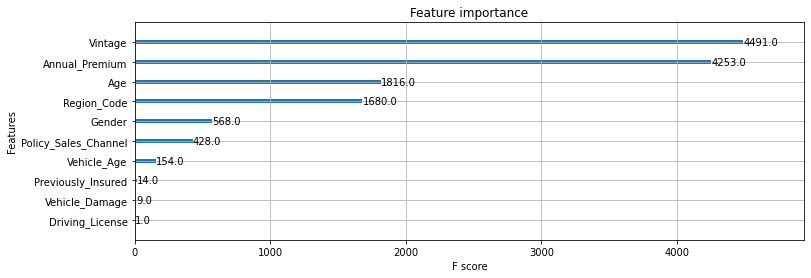

In [85]:
plot_importance(xgb3)
plt.show()

### Etape 6 : Learning rate

Lastly, we should lower the learning rate and add more trees. Lets use the cv function of XGBoost to do the job again.

In [86]:
xgb4 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=50,
 min_child_weight=4,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.9,
 reg_alpha=1e-5,
 objective= 'binary:logistic',
 nthread=7,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb4, train, predictors)

C:\Users\mathi\.virtualenvs\ISFA-prj-datascience-4Z2Vzt1R\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Model Report
Accuracy :  0.8726133239120751
f1 :  0.6059396531242576


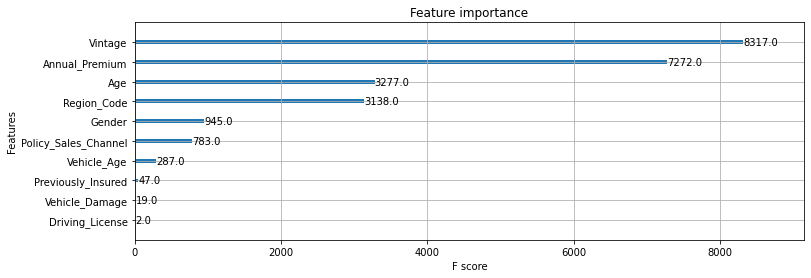

In [87]:
plot_importance(xgb4)
plt.show()

In [80]:
params = {
    # "learning_rate": 0.003,
    # "max_depth": 5,
    # "eta":0.01, 
    # "nfold":5,
    # "nrounds":716
}

In [37]:
gsearch1.grid_scores_

AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'

In [ ]:
params = {
    # "learning_rate": 0.003,
    # "max_depth": 5,
    # "eta":0.01, 
    # "nfold":5,
    # "nrounds":716
}

In [ ]:
xgb = XGBClassifier(**params)
xgb.fit(X_train, Y_train)

Puis, nous pouvons directement entrainer le modèle et l'afficher grâce à notre fonction *result_model*.

Le F1-score n'est pas satisfaisant ce qui est évident au regard de la matrice de confusion. Tout est prédit en positif.

<br><br><br><br>